In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [6]:
df=pd.read_excel('.\\Accidents_ASN.xlsx')
df=df.fillna(np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4295 entries, 0 to 4294
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   4295 non-null   object 
 1   Time                   4151 non-null   object 
 2   Type                   4295 non-null   object 
 3   Owner/operator         4277 non-null   object 
 4   Registration           4295 non-null   object 
 5   MSN                    4295 non-null   object 
 6   Year of manufacture    3923 non-null   float64
 7   Total airframe hrs     2883 non-null   object 
 8   Cycles                 769 non-null    object 
 9   Engine model           3891 non-null   object 
 10  Fatalities             4295 non-null   object 
 11  Other fatalities       4295 non-null   int64  
 12  Aircraft damage        4295 non-null   object 
 13  Category               4291 non-null   object 
 14  Location               4295 non-null   object 
 15  Phas

In [7]:
df=df[(df['Nature']=='Passenger')|(df['Nature']=='Passenger - Scheduled')|(df['Nature']=='Cargo')]
df=df[df['Category']=='Accident']
df=df[df['Confidence Rating']!='Information is only available from news, social media or unofficial sources']

In [8]:
import fasttext

lang_model=fasttext.load_model(".\\lid.176.ftz")
def predict_language(text,threshold=0.5,default='en'):
    text=text.replace('\n','')
    label,probas=lang_model.predict(text)
    lang=label[0].replace('__label__','')
    proba=probas[0]
    if proba<threshold:
        return default
    else:
        return lang

In [9]:
df=df.dropna(subset=['Narrative'])

In [10]:
df['lang']=df['Narrative'].apply(predict_language)
df['lang'].value_counts()

lang
en    2339
es       7
pt       3
de       2
fr       2
Name: count, dtype: int64

In [11]:
df=df[df['lang']=='en']

In [12]:
import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[w-]*',text)
df['text']=df['Narrative'].apply(tokenize)
df['length']=df['text'].apply(len)

In [13]:
df=df[df['length']>=50]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2266 entries, 0 to 4292
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   2266 non-null   object 
 1   Time                   2203 non-null   object 
 2   Type                   2266 non-null   object 
 3   Owner/operator         2266 non-null   object 
 4   Registration           2266 non-null   object 
 5   MSN                    2266 non-null   object 
 6   Year of manufacture    2105 non-null   float64
 7   Total airframe hrs     1463 non-null   object 
 8   Cycles                 498 non-null    object 
 9   Engine model           2115 non-null   object 
 10  Fatalities             2266 non-null   object 
 11  Other fatalities       2266 non-null   int64  
 12  Aircraft damage        2266 non-null   object 
 13  Category               2266 non-null   object 
 14  Location               2266 non-null   object 
 15  Phase    

In [14]:
df.to_excel('accidents_classification.xlsx',index=False)

In [15]:
def year(data):
    return data.split(' ')[-1]
def month(data):
    return data.split(' ')[2]

In [16]:
df['year']=df['Date'].map(year)
df['month']=df['Date'].map(month)
time=df['year'].value_counts().to_frame().reset_index()
month=df['month'].value_counts().to_frame().reset_index()

In [17]:
time=time.sort_values(by='year',ascending=True)

In [18]:
damage=df['Aircraft damage'].value_counts().to_frame().reset_index()
modify={' Substantial, repaired':'Substantial',' Destroyed, written off':'Destroyed',
        ' Substantial, written off':'Substantial',' Minor, repaired':'Minor',
        ' Unknown, repaired':'Unknown',' Minor, written off':'Minor',
        ' None':'None',' Substantial':'Substantial',' Minor':'Minor',
        ' Unknown':'Unknown',' ':'Unknown',' Destroyed':'Destroyed'
        }
df['damage']=df['Aircraft damage'].map(modify)

In [19]:
def fatalities(text):
    f=text.split(' ')[1]
    if f=='':
        return 0
    else:
        return f

In [20]:
df['casualty']=df['Fatalities'].map(fatalities).astype(int)
df['total_fatalities']=df['casualty']+df['Other fatalities']
df_damage=pd.get_dummies(df['damage'],prefix='damage').astype(int)
df=pd.concat([df,df_damage],axis=1)

In [21]:
df_grouped=df.groupby('year').agg({'total_fatalities':'sum','month':'count','damage_Destroyed':'sum',
                                   'damage_Substantial':'sum','damage_Minor':'sum','damage_None':'sum',
                                   'damage_Unknown':'sum'}).reset_index()
df_grouped

,year,total_fatalities,month,damage_Destroyed,damage_Substantial,damage_Minor,damage_None,damage_Unknown
0,1990,298,34,18,13,1,2,0
1,1991,250,27,19,8,0,0,0
2,1992,353,36,16,13,4,3,0
3,1993,383,42,13,17,6,6,0
4,1994,636,43,19,18,3,3,0
5,1995,524,55,22,25,3,4,1
6,1996,1564,48,25,21,0,2,0
7,1997,663,63,23,19,5,16,0
8,1998,710,71,29,30,3,8,1
9,1999,186,84,23,38,4,19,0


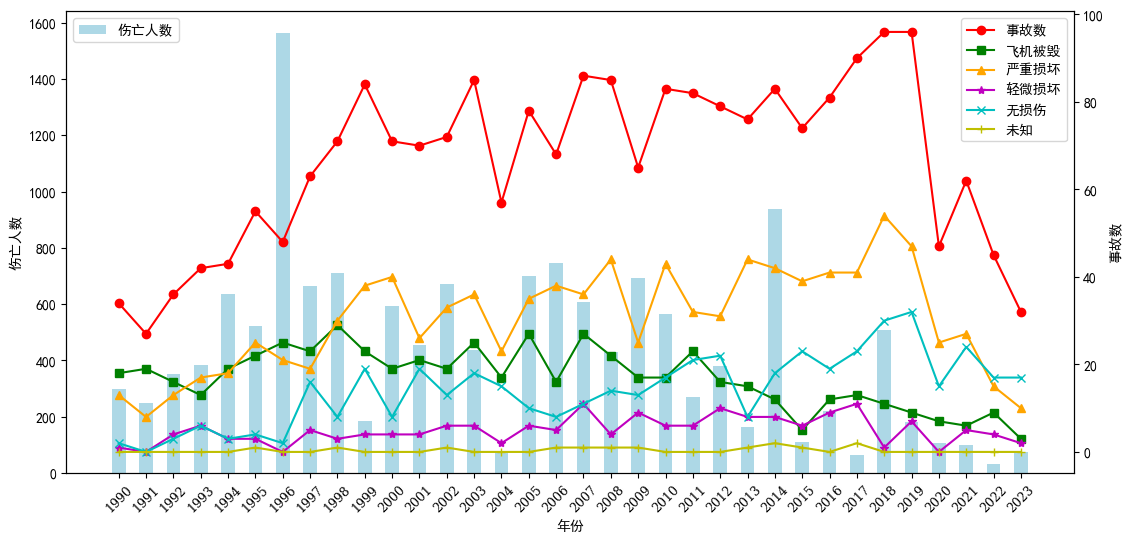

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']   
fig, ax1 = plt.subplots(figsize=(13, 6))
ax1.bar(df_grouped['year'], df_grouped['total_fatalities'], color='lightblue', label='伤亡人数', width=0.5)
ax1.set_xlabel('年份')
ax1.set_ylabel('伤亡人数')
plt.xticks(fontsize=9, fontfamily='serif')
ax2 = ax1.twinx()
ax2.plot(df_grouped['year'], df_grouped['month'], color='red', label='事故数', marker='o')
ax2.plot(df_grouped['year'], df_grouped['damage_Destroyed'], color='green', label='飞机被毁', marker='s')
ax2.plot(df_grouped['year'], df_grouped['damage_Substantial'], color='orange', label='严重损坏', marker='^')
ax2.plot(df_grouped['year'], df_grouped['damage_Minor'], color='m', label='轻微损坏', marker='*')
ax2.plot(df_grouped['year'], df_grouped['damage_None'], color='c', label='无损伤', marker='x')
ax2.plot(df_grouped['year'], df_grouped['damage_Unknown'], color='y', label='未知', marker='+')
ax2.set_ylabel('事故数')

ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [23]:
damage=df['Aircraft damage'].value_counts().to_frame().reset_index()
modify={' Substantial, repaired':'Substantial',' Destroyed, written off':'Destroyed',
        ' Substantial, written off':'Substantial',' Minor, repaired':'Minor',
        ' Unknown, repaired':'Unknown',' Minor, written off':'Minor',
        ' None':'None',' Substantial':'Substantial',' Minor':'Minor',
        ' Unknown':'Unknown',' ':'Unknown',' Destroyed':'Destroyed'
        }
df['damage']=df['Aircraft damage'].map(modify)

In [24]:
df=df.dropna(subset=['Phase'])
phase=df['Phase'].value_counts().to_frame().reset_index()
sort_order=[' Taxi',' Take off',' Initial climb',' En route',' Approach',' Landing',' Pushback / towing',' Standing',' Unknown']
chinese=['滑行','起飞','爬升','巡航','进近','着陆','停留','推回/拖曳','未知']
phase['Phase'] = pd.Categorical(phase['Phase'], categories=sort_order, ordered=True)

In [25]:
phase=phase.dropna(subset=['Phase'])
phase=phase.sort_values('Phase')
phase['c_phase']=chinese

In [26]:
phase=phase[['c_phase','count']][::-1]

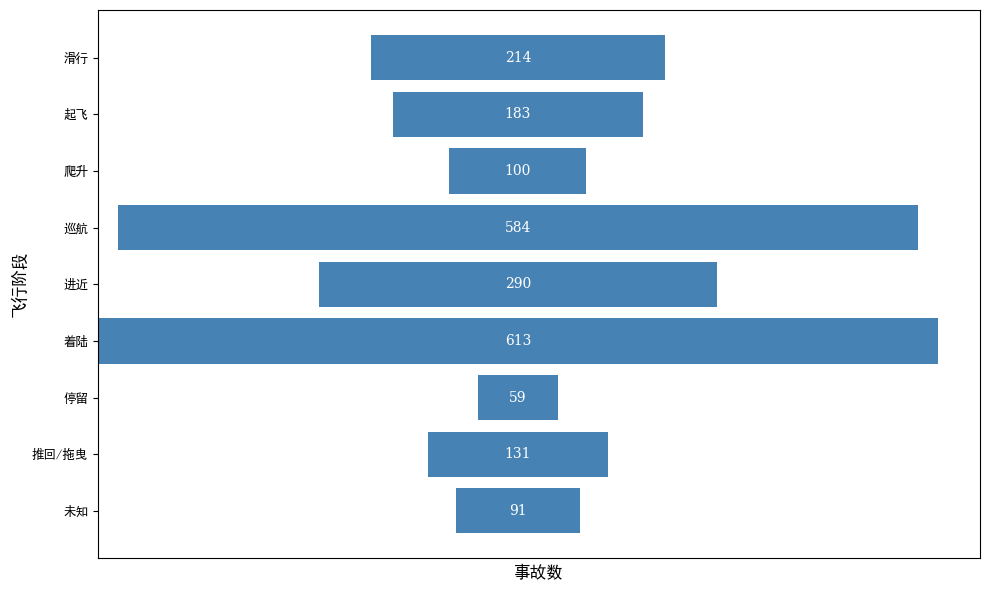

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] 

fig, ax = plt.subplots(figsize=(10, 6))

max_value = phase['count'].max()
ax.barh(phase['c_phase'], phase['count'], color='steelblue', left=(max_value - phase['count']) / 2)

# 在条形上添加数值标签
for index, value in enumerate(phase['count']):
    ax.text(max_value / 2, index, str(value), va='center', ha='center', color='white',fontdict={'family': 'serif'})

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

font = {'family': 'SimHei',  # 字体类型
        'size': 12,          # 字体大小
       }
# 设置X轴标签和Y轴标签
ax.set_xlabel('事故数',fontdict=font)
ax.set_ylabel('飞行阶段',fontdict=font)
plt.yticks(fontsize=9, fontfamily='SimHei')
# 显示图表
plt.tight_layout()
plt.show()